# TRABAJO UT13: MODELO PREENTRENADO DE HUGGING FACE

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/'
train_dir = os.path.join(base_dir, 'cancer_data/train')
test_dir = os.path.join(base_dir, 'cancer_data/test')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 2667 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
# Procesamiento de imágenes
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
# Modificar la capa de clasificación
num_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_features, 2)

In [ ]:
# Definir función de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Entrenamiento
num_epochs = 20  # Número de épocas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Usar GPU si está disponible
model.to(device)  # Mover el modelo a GPU si está disponible

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
!pip install torchsummary

In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary

class WrappedResNet(torch.nn.Module):
    def __init__(self, model):
        super(WrappedResNet, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        return outputs.logits

wrapped_model = WrappedResNet(model)

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

Tras haber probado usar el summary durante mucho tiempo y que no funcionase, al final le he dicho al chatgpt que me lo hiciese por que no había manera de que funcionara

In [ ]:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
            ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256, 56, 56]          16,384
      BatchNorm2d-15          [-1, 256, 56, 56]             512
           Conv2d-16           [-1, 64, 56, 56]           4,096
      BatchNorm2d-17           [-1, 64, 56, 56]             128
            ReLU-18           [-1, 64, 56, 56]               0
           Conv2d-19           [-1, 64, 56, 56]          36,864
      BatchNorm2d-20           [-1, 64, 56, 56]             128
            ReLU-21           [-1, 64, 56, 56]               0
           Conv2d-22          [-1, 256, 56, 56]          16,384
      BatchNorm2d-23          [-1, 256, 56, 56]             512
            ReLU-24          [-1, 256, 56, 56]               0
           Conv2d-25           [-1, 64, 56, 56]           4,096
      BatchNorm2d-26           [-1, 64, 56, 56]             128
            ReLU-27           [-1, 64, 56, 56]               0
           Conv2d-28           [-1, 64, 56, 56]          36,864
      BatchNorm2d-29           [-1, 64, 56, 56]             128
            ReLU-30           [-1, 64, 56, 56]               0
           Conv2d-31          [-1, 256, 56, 56]          16,384
      BatchNorm2d-32          [-1, 256, 56, 56]             512
            ReLU-33          [-1, 256, 56, 56]               0
           Conv2d-34          [-1, 512, 28, 28]         131,072
      BatchNorm2d-35          [-1, 512, 28, 28]           1,024
           Conv2d-36          [-1, 128, 28, 28]          32,768
      BatchNorm2d-37          [-1, 128, 28, 28]             256
            ReLU-38          [-1, 128, 28, 28]               0
           Conv2d-39          [-1, 128, 28, 28]         147,456
      BatchNorm2d-40          [-1, 128, 28, 28]             256
            ReLU-41          [-1, 128, 28, 28]               0
           Conv2d-42          [-1, 512, 28, 28]          65,536
      BatchNorm2d-43          [-1, 512, 28, 28]           1,024
            ReLU-44          [-1, 512, 28, 28]               0
           Conv2d-45          [-1, 512, 28, 28]         131,072
      BatchNorm2d-46          [-1, 512, 28, 28]           1,024
           Conv2d-47          [-1, 128, 28, 28]          32,768
      BatchNorm2d-48          [-1, 128, 28, 28]             256
            ReLU-49          [-1, 128, 28, 28]               0
           Conv2d-50          [-1, 128, 28, 28]         147,456
      BatchNorm2d-51          [-1, 128, 28, 28]             256
            ReLU-52          [-1, 128, 28, 28]               0
           Conv2d-53          [-1, 512, 28, 28]          65,536
      BatchNorm2d-54          [-1, 512, 28, 28]           1,024
            ReLU-55          [-1, 512, 28, 28]               0
           Conv2d-56          [-1, 128, 28, 28]          32,768
      BatchNorm2d-57          [-1, 128, 28, 28]             256
            ReLU-58          [-1, 128, 28, 28]               0
           Conv2d-59          [-1, 128, 28, 28]         147,456
      BatchNorm2d-60          [-1, 128, 28, 28]             256
            ReLU-61          [-1, 128, 28, 28]               0
           Conv2d-62          [-1, 512, 28, 28]          65,536
      BatchNorm2d-63          [-1, 512, 28, 28]           1,024
            ReLU-64          [-1, 512, 28, 28]               0
           Conv2d-65          [-1, 128, 28, 28]          32,768
      BatchNorm2d-66          [-1, 128, 28, 28]             256
            ReLU-67          [-1, 128, 28, 28]               0
           Conv2d-68          [-1, 128, 28, 28]         147,456
      BatchNorm2d-69          [-1, 128, 28, 28]             256
            ReLU-70          [-1, 128, 28, 28]               0
           Conv2d-71          [-1, 512, 28, 28]          65,536
      BatchNorm2d-72          [-1, 512, 28, 28]           1,024
            ReLU-73          [-1, 512, 28, 28]               0
           Conv2d-74         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-75         [-1, 1024, 14, 14]           2,048
           Conv2d-76          [-1, 256, 14, 14]         131,072
      BatchNorm2d-77          [-1, 256, 14, 14]             512
            ReLU-78          [-1, 256, 14, 14]               0
           Conv2d-79          [-1, 256, 14, 14]         589,824
      BatchNorm2d-80          [-1, 256, 14, 14]             512
            ReLU-81          [-1, 256, 14, 14]               0
           Conv2d-82         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-83         [-1, 1024, 14, 14]           2,048
            ReLU-84         [-1, 1024, 14, 14]               0
           Conv2d-85         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-86         [-1, 1024, 14, 14]           2,048
           Conv2d-87          [-1, 256, 14, 14]         131,072
      BatchNorm2d-88          [-1, 256, 14, 14]             512
            ReLU-89          [-1, 256, 14, 14]               0
           Conv2d-90          [-1, 256, 14, 14]         589,824
      BatchNorm2d-91          [-1, 256, 14, 14]             512
            ReLU-92          [-1, 256, 14, 14]               0
           Conv2d-93         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-94         [-1, 1024, 14, 14]           2,048
            ReLU-95         [-1, 1024, 14, 14]               0
           Conv2d-96         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-97         [-1, 1024, 14, 14]           2,048
           Conv2d-98          [-1, 256, 14, 14]         131,072
      BatchNorm2d-99          [-1, 256, 14, 14]             512
           ReLU-100          [-1, 256, 14, 14]               0
          Conv2d-101          [-1, 256, 14, 14]         589,824
      BatchNorm2d-102          [-1, 256, 14, 14]             512
           ReLU-103          [-1, 256, 14, 14]               0
          Conv2d-104         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-105         [-1, 1024, 14, 14]           2,048
           ReLU-106         [-1, 1024, 14, 14]               0
          Conv2d-107         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-108         [-1, 1024, 14, 14]           2,048
          Conv2d-109          [-1, 256, 14, 14]         131,072
      BatchNorm2d-110          [-1, 256, 14, 14]             512
           ReLU-111          [-1, 256, 14, 14]               0
          Conv2d-112          [-1, 256, 14, 14]         589,824
      BatchNorm2d-113          [-1, 256, 14, 14]             512
           ReLU-114          [-1, 256, 14, 14]               0
          Conv2d-115         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-116         [-1, 1024, 14, 14]           2,048
           ReLU-117         [-1, 1024, 14, 14]               0
          Conv2d-118         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-119         [-1, 1024, 14, 14]           2,048
          Conv2d-120          [-1, 256, 14, 14]         131,072
      BatchNorm2d-121          [-1, 256, 14, 14]             512
           ReLU-122          [-1, 256, 14, 14]               0
          Conv2d-123          [-1, 256, 14, 14]         589,824
      BatchNorm2d-124          [-1, 256, 14, 14]             512
           ReLU-125          [-1, 256, 14, 14]               0
          Conv2d-126         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-127         [-1, 1024, 14, 14]           2,048
           ReLU-128         [-1, 1024, 14, 14]               0
          Conv2d-129         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-130         [-1, 1024, 14, 14]           2,048
          Conv2d-131          [-1, 256, 14, 14]         131,072
      BatchNorm2d-132          [-1, 256, 14, 14]             512
           ReLU-133          [-1, 256, 14, 14]               0
          Conv2d-134          [-1, 256, 14, 14]         589,824
      BatchNorm2d-135          [-1, 256, 14, 14]             512
           ReLU-136          [-1, 256, 14, 14]               0
          Conv2d-137         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-138         [-1, 1024, 14, 14]           2,048
           ReLU-139         [-1, 1024, 14, 14]               0
          Conv2d-140         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-141         [-1, 1024, 14, 14]           2,048
          Conv2d-142          [-1, 256, 14, 14]         131,072
      BatchNorm2d-143          [-1, 256, 14, 14]             512
           ReLU-144          [-1, 256, 14, 14]               0
          Conv2d-145          [-1, 256, 14, 14]         589,824
      BatchNorm2d-146          [-1, 256, 14, 14]             512
           ReLU-147          [-1, 256, 14, 14]               0
          Conv2d-148         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-149         [-1, 1024, 14, 14]           2,048
           ReLU-150         [-1, 1024, 14, 14]               0
          Conv2d-151         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-152         [-1, 1024, 14, 14]           2,048
          Conv2d-153          [-1, 256, 14, 14]         131,072
      BatchNorm2d-154          [-1, 256, 14, 14]             512
           ReLU-155          [-1, 256, 14, 14]               0
          Conv2d-156          [-1, 256, 14, 14]         589,824
      BatchNorm2d-157          [-1, 256, 14, 14]             512
           ReLU-158          [-1, 256, 14, 14]               0
          Conv2d-159         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-160         [-1, 1024, 14, 14]           2,048
           ReLU-161         [-1, 1024, 14, 14]               0
          Conv2d-162         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-163         [-1, 1024, 14, 14]           2,048
          Conv2d-164          [-1, 256, 14, 14]         131,072
      BatchNorm2d-165          [-1, 256, 14, 14]             512
           ReLU-166          [-1, 256, 14, 14]               0
          Conv2d-167          [-1, 256, 14, 14]         589,824
      BatchNorm2d-168          [-1, 256, 14, 14]             512
           ReLU-169          [-1, 256, 14, 14]               0
          Conv2d-170         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-171         [-1, 1024, 14, 14]           2,048
           ReLU-172         [-1, 1024, 14, 14]               0
          Conv2d-173         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-174         [-1, 1024, 14, 14]           2,048
          Conv2d-175          [-1, 256, 14, 14]         131,072
      BatchNorm2d-176          [-1, 256, 14, 14]             512
           ReLU-177          [-1, 256, 14, 14]               0
          Conv2d-178          [-1, 256, 14, 14]         589,824
      BatchNorm2d-179          [-1, 256, 14, 14]             512
           ReLU-180          [-1, 256, 14, 14]               0
          Conv2d-181         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-182         [-1, 1024, 14, 14]           2,048
           ReLU-183         [-1, 1024, 14, 14]               0
          Conv2d-184         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-185         [-1, 1024, 14, 14]           2,048
          Conv2d-186          [-1, 256, 14, 14]         131,072
      BatchNorm2d-187          [-1, 256, 14, 14]             512
           ReLU-188          [-1, 256, 14, 14]               0
          Conv2d-189          [-1, 256, 14, 14]         589,824
      BatchNorm2d-190          [-1, 256, 14, 14]             512
           ReLU-191          [-1, 256, 14, 14]               0
          Conv2d-192         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-193         [-1, 1024, 14, 14]           2,048
           ReLU-194         [-1, 1024, 14, 14]               0
          Conv2d-195         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-196         [-1, 1024, 14, 14]           2,048
          Conv2d-197          [-1, 256, 14, 14]         131,072
      BatchNorm2d-198          [-1, 256, 14, 14]             512
           ReLU-199          [-1, 256, 14, 14]               0
          Conv2d-200          [-1, 256, 14, 14]         589,824
      BatchNorm2d-201          [-1, 256, 14, 14]             512
           ReLU-202          [-1, 256, 14, 14]               0
          Conv2d-203         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-204         [-1, 1024, 14, 14]           2,048
           ReLU-205         [-1, 1024, 14, 14]               0
          Conv2d-206         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-207         [-1, 1024, 14, 14]           2,048
          Conv2d-208          [-1, 256, 14, 14]         131,072
      BatchNorm2d-209          [-1, 256, 14, 14]             512
           ReLU-210          [-1, 256, 14, 14]               0
          Conv2d-211          [-1, 256, 14, 14]         589,824
      BatchNorm2d-212          [-1, 256, 14, 14]             512
           ReLU-213          [-1, 256, 14, 14]               0
          Conv2d-214         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-215         [-1, 1024, 14, 14]           2,048
           ReLU-216         [-1, 1024, 14, 14]               0
          Conv2d-217         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-218         [-1, 1024, 14, 14]           2,048
          Conv2d-219          [-1, 256, 14, 14]         131,072
      BatchNorm2d-220          [-1, 256, 14, 14]             512
           ReLU-221          [-1, 256, 14, 14]               0
          Conv2d-222          [-1, 256, 14, 14]         589,824
      BatchNorm2d-223          [-1, 256, 14, 14]             512
           ReLU-224          [-1, 256, 14, 14]               0
          Conv2d-225         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-226         [-1, 1024, 14, 14]           2,048
           ReLU-227         [-1, 1024, 14, 14]               0
          Conv2d-228         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-229         [-1, 1024, 14, 14]           2,048
          Conv2d-230          [-1, 256, 14, 14]         131,072
      BatchNorm2d-231          [-1, 256, 14, 14]             512
           ReLU-232          [-1, 256, 14, 14]               0
          Conv2d-233          [-1, 256, 14, 14]         589,824
      BatchNorm2d-234          [-1, 256, 14, 14]             512
           ReLU-235          [-1, 256, 14, 14]               0
          Conv2d-236         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-237         [-1, 1024, 14, 14]           2,048
           ReLU-238         [-1, 1024, 14, 14]               0
          Conv2d-239         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-240         [-1, 1024, 14, 14]           2,048
          Conv2d-241          [-1, 256, 14, 14]         131,072
      BatchNorm2d-242          [-1, 256, 14, 14]             512
           ReLU-243          [-1, 256, 14, 14]               0
          Conv2d-244          [-1, 256, 14, 14]         589,824
      BatchNorm2d-245          [-1, 256, 14, 14]             512
           ReLU-246          [-1, 256, 14, 14]               0
          Conv2d-247         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-248         [-1, 1024, 14, 14]           2,048
           ReLU-249         [-1, 1024, 14, 14]               0
          Conv2d-250         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-251         [-1, 1024, 14, 14]           2,048
          Conv2d-252          [-1, 256, 14, 14]         131,072
      BatchNorm2d-253          [-1, 256, 14, 14]             512
           ReLU-254          [-1, 256, 14, 14]               0
          Conv2d-255          [-1, 256, 14, 14]         589,824
      BatchNorm2d-256          [-1, 256, 14, 14]             512
           ReLU-257          [-1, 256, 14, 14]               0
          Conv2d-258         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-259         [-1, 1024, 14, 14]           2,048
           ReLU-260         [-1, 1024, 14, 14]               0
          Conv2d-261         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-262         [-1, 1024, 14, 14]           2,048
          Conv2d-263          [-1, 256, 14, 14]         131,072
      BatchNorm2d-264          [-1, 256, 14, 14]             512
           ReLU-265          [-1, 256, 14, 14]               0
          Conv2d-266          [-1, 256, 14, 14]         589,824
      BatchNorm2d-267          [-1, 256, 14, 14]             512
           ReLU-268          [-1, 256, 14, 14]               0
          Conv2d-269         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-270         [-1, 1024, 14, 14]           2,048
           ReLU-271         [-1, 1024, 14, 14]               0
          Conv2d-272         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-273         [-1, 1024, 14, 14]           2,048
          Conv2d-274          [-1, 256, 14, 14]         131,072
      BatchNorm2d-275          [-1, 256, 14, 14]             512
           ReLU-276          [-1, 256, 14, 14]               0
          Conv2d-277          [-1, 256, 14, 14]         589,824
      BatchNorm2d-278          [-1, 256, 14, 14]             512
           ReLU-279          [-1, 256, 14, 14]               0
          Conv2d-280         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-281         [-1, 1024, 14, 14]           2,048
           ReLU-282         [-1, 1024, 14, 14]               0
          Conv2d-283         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-284         [-1, 1024, 14, 14]           2,048
          Conv2d-285          [-1, 256, 14, 14]         131,072
      BatchNorm2d-286          [-1, 256, 14, 14]             512
           ReLU-287          [-1, 256, 14, 14]               0
          Conv2d-288          [-1, 256, 14, 14]         589,824
      BatchNorm2d-289          [-1, 256, 14, 14]             512
           ReLU-290          [-1, 256, 14, 14]               0
          Conv2d-291         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-292         [-1, 1024, 14, 14]           2,048
           ReLU-293         [-1, 1024, 14, 14]               0
          Conv2d-294         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-295         [-1, 1024, 14, 14]           2,048
          Conv2d-296          [-1, 256, 14, 14]         131,072
      BatchNorm2d-297          [-1, 256, 14, 14]             512
           ReLU-298          [-1, 256, 14, 14]               0
          Conv2d-299          [-1, 256, 14, 14]         589,824
      BatchNorm2d-300          [-1, 256, 14, 14]             512
           ReLU-301          [-1, 256, 14, 14]               0
          Conv2d-302         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-303         [-1, 1024, 14, 14]           2,048
           ReLU-304         [-1, 1024, 14, 14]               0
          Conv2d-305         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-306         [-1, 1024, 14, 14]           2,048
          Conv2d-307          [-1, 256, 14, 14]         131,072
      BatchNorm2d-308          [-1, 256, 14, 14]             512
           ReLU-309          [-1, 256, 14, 14]               0
          Conv2d-310          [-1, 256, 14, 14]         589,824
      BatchNorm2d-311          [-1, 256, 14, 14]             512
           ReLU-312          [-1, 256, 14, 14]               0
          Conv2d-313         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-314         [-1, 1024, 14, 14]           2,048
           ReLU-315         [-1, 1024, 14, 14]               0
          Conv2d-316         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-317         [-1, 1024, 14, 14]           2,048
          Conv2d-318          [-1, 256, 14, 14]         131,072
      BatchNorm2d-319          [-1, 256, 14, 14]             512
           ReLU-320          [-1, 256, 14, 14]               0
          Conv2d-321          [-1, 256, 14, 14]         589,824
      BatchNorm2d-322          [-1, 256, 14, 14]             512
           ReLU-323          [-1, 256, 14, 14]               0
          Conv2d-324         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-325         [-1, 1024, 14, 14]           2,048
           ReLU-326         [-1, 1024, 14, 14]               0
          Conv2d-327         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-328         [-1, 1024, 14, 14]           2,048
          Conv2d-329          [-1, 256, 14, 14]         131,072
      BatchNorm2d-330          [-1, 256, 14, 14]             512
           ReLU-331          [-1, 256, 14, 14]               0
          Conv2d-332          [-1, 256, 14, 14]         589,824
      BatchNorm2d-333          [-1, 256, 14, 14]             512
           ReLU-334          [-1, 256, 14, 14]               0
          Conv2d-335         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-336         [-1, 1024, 14, 14]           2,048
           ReLU-337         [-1, 1024, 14, 14]               0
          Conv2d-338         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-339         [-1, 1024, 14, 14]           2,048
          Conv2d-340          [-1, 256, 14, 14]         131,072
      BatchNorm2d-341          [-1, 256, 14, 14]             512
           ReLU-342          [-1, 256, 14, 14]               0
          Conv2d-343          [-1, 256, 14, 14]         589,824
      BatchNorm2d-344          [-1, 256, 14, 14]             512
           ReLU-345          [-1, 256, 14, 14]               0
          Conv2d-346         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-347         [-1, 1024, 14, 14]           2,048
           ReLU-348         [-1, 1024, 14, 14]               0
          Conv2d-349         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-350         [-1, 1024, 14, 14]           2,048
          Conv2d-351          [-1, 256, 14, 14]         131,072
      BatchNorm2d-352          [-1, 256, 14, 14]             512
           ReLU-353          [-1, 256, 14, 14]               0
          Conv2d-354          [-1, 256, 14, 14]         589,824
      BatchNorm2d-355          [-1, 256, 14, 14]             512
           ReLU-356          [-1, 256, 14, 14]               0
          Conv2d-357         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-358         [-1, 1024, 14, 14]           2,048
           ReLU-359         [-1, 1024, 14, 14]               0
          Conv2d-360         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-361         [-1, 1024, 14, 14]           2,048
          Conv2d-362          [-1, 256, 14, 14]         131,072
      BatchNorm2d-363          [-1, 256, 14, 14]             512
           ReLU-364          [-1, 256, 14, 14]               0
          Conv2d-365          [-1, 256, 14, 14]         589,824
      BatchNorm2d-366          [-1, 256, 14, 14]             512
           ReLU-367          [-1, 256, 14, 14]               0
          Conv2d-368         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-369         [-1, 1024, 14, 14]           2,048
           ReLU-370         [-1, 1024, 14, 14]               0
          Conv2d-371         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-372         [-1, 1024, 14, 14]           2,048
          Conv2d-373          [-1, 256, 14, 14]         131,072
      BatchNorm2d-374          [-1, 256, 14, 14]             512
           ReLU-375          [-1, 256, 14, 14]               0
          Conv2d-376          [-1, 256, 14, 14]         589,824
      BatchNorm2d-377          [-1, 256, 14, 14]             512
           ReLU-378          [-1, 256, 14, 14]               0
          Conv2d-379         [-1, 1024, 14, 14]         262,144
      BatchNorm2d-380         [-1, 1024, 14, 14]           2,048
           ReLU-381         [-1, 1024, 14, 14]               0
          Conv2d-382         [-1, 1024, 14, 14]         524,288
      BatchNorm2d-383         [-1, 1024, 14, 14]           2,048
AdaptiveAvgPool2d-384           [-1, 1024, 1, 1]               0
           Linear-385                  [-1, 10]          10,250
================================================================
Total params: 25,616,746
Trainable params: 25,616,746
Non-trainable params: 0
================================================================


In [ ]:
# Crear un dataset personalizado a partir de los generadores de datos de Keras
class CustomDataset(Dataset):
    def __init__(self, generator):
        self.generator = generator
        self.data = [(x, y) for x, y in zip(self.generator[0][0], self.generator[0][1])]
        for i in range(1, len(self.generator)):
            self.data.extend([(x, y) for x, y in zip(self.generator[i][0], self.generator[i][1])])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = torch.tensor(image).permute(2, 0, 1)
        label = torch.tensor(label).long()
        return image, label

In [ ]:
train_dataset = CustomDataset(train_generator)
test_dataset = CustomDataset(test_generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Funcionalidad de DataLoader

Carga de Datos en Lotes: La clase DataLoader carga los datos en lotes (batches) en lugar de cargar todo el conjunto de datos de una vez. Esto es útil para entrenar modelos en GPUs, ya que permite manejar grandes conjuntos de datos que no cabrían en la memoria de la GPU.

Barajado de Datos: Cuando shuffle=True, los datos se barajan en cada época (epoch) para garantizar que el modelo no aprenda patrones específicos del orden de los datos.

Paralelismo: DataLoader puede usar múltiples subprocesos para cargar los datos en paralelo, lo que acelera el proceso de carga de datos.

Iteración Fácil: Proporciona una manera fácil de iterar sobre los datos en bucles de entrenamiento, devolviendo lotes de datos de entrada y sus etiquetas correspondientes.

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 0.018067552832300344
Epoch 2, Loss: 0.02007171429760915
Epoch 3, Loss: 0.013010390149810562
Epoch 4, Loss: 0.0035259417172710528
Epoch 5, Loss: 0.008409461092664319
Epoch 6, Loss: 0.003977702193619085
Epoch 7, Loss: 0.002427216289929458
Epoch 8, Loss: 0.001053236240512065
Epoch 9, Loss: 0.008858164681820805
Epoch 10, Loss: 0.008814776364964754
Epoch 11, Loss: 0.02201228413486249
Epoch 12, Loss: 0.012078035884423159
Epoch 13, Loss: 0.010674504746843706
Epoch 14, Loss: 0.017579454887839217
Epoch 15, Loss: 0.012006693937932834
Epoch 16, Loss: 0.005879406152200231
Epoch 17, Loss: 0.03288581997830555
Epoch 18, Loss: 0.03046895000928392
Epoch 19, Loss: 0.0217637694482359
Epoch 20, Loss: 0.011572765711683869


In [ ]:
# Evaluación del modelo
model.eval()
test_loss = 0.0
correct = 0
all_labels = []
all_probs = []

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs.logits, labels).item()
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()

        # Guardar etiquetas reales y probabilidades predichas
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss}, Accuracy: {accuracy}")

Test Loss: 0.016759984000501306, Accuracy: 0.8878787878787879


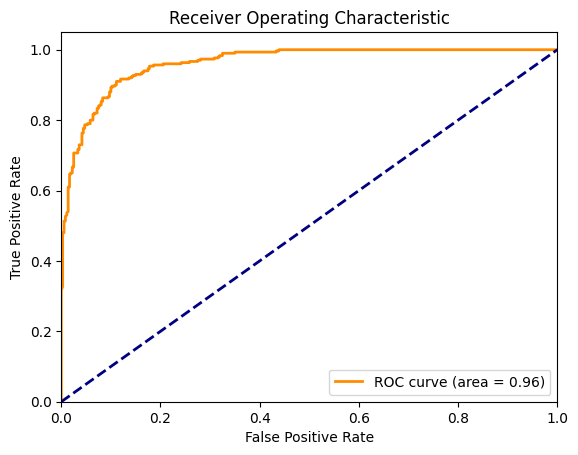

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular y graficar la curva ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

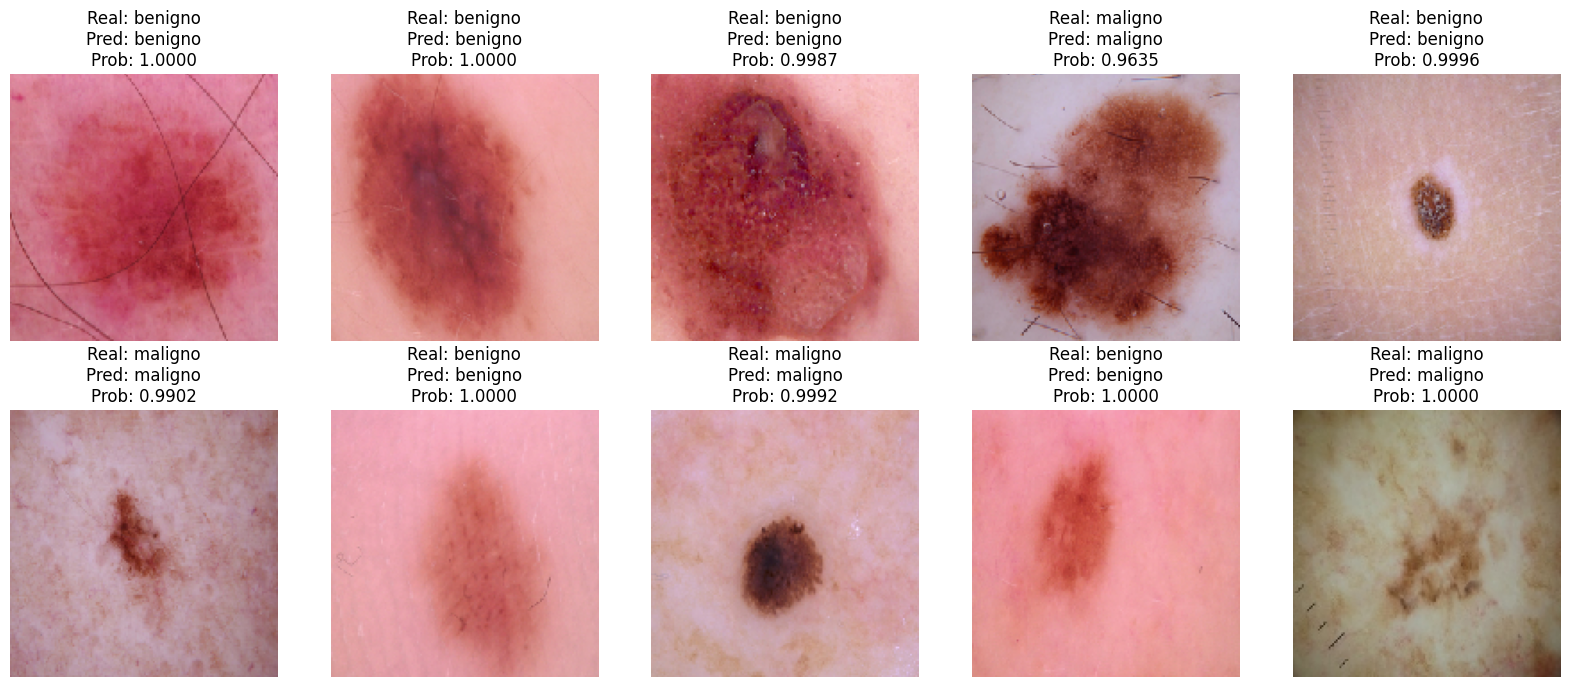

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un lote de datos del conjunto de prueba
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Realizar predicciones en este lote
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_classes = torch.argmax(probabilities, dim=-1)

# Mover datos y predicciones a la CPU para visualización
inputs = inputs.cpu()
labels = labels.cpu()
probabilities = probabilities.cpu()
predicted_classes = predicted_classes.cpu()

# Definir las etiquetas
class_labels = {0: "benigno", 1: "maligno"}

# Mostrar las primeras 10 imágenes con sus etiquetas reales, predicciones y probabilidades
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    image = inputs[i].permute(1, 2, 0).numpy()  # Cambiar de (C, H, W) a (H, W, C)
    label = class_labels[labels[i].item()]
    predicted = class_labels[predicted_classes[i].item()]
    probability = probabilities[i, predicted_classes[i]].item()

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Real: {label}\nPred: {predicted}\nProb: {probability:.4f}')

plt
